In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
import numpy as np
import torch.nn.functional as F
from collections import Counter
import random
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt



In [2]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
#tknzr = TweetTokenizer()


def _split_tokenizer(x):  # noqa: F821
    return x.split()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('/content/gdrive/My Drive/Assignment2/train.csv') 
df2 = pd.read_csv('/content/gdrive/My Drive/Assignment2/val.csv')
df3 = pd.read_csv('/content/gdrive/My Drive/Assignment2/test_without_labels.csv')

Mounted at /content/gdrive


In [7]:
new = torch.load('/content/gdrive/My Drive/Assignment2/best_model_cos v2.pt')

In [ ]:
#This is data preprocessing including convert to lower case, lemmatization and tokenization
train_x=[]
for x in df['sents']:
    x = _split_tokenizer(x.lower())#lemmatizer.lemmatize(x).lower())
    train_x.append(x)

val_x=[]
for x in df2['sents']:
    x = _split_tokenizer(x.lower())#lemmatizer.lemmatize(x).lower())
    val_x.append(x)
    
test_x=[]
for x in df3['sents']:
    x = _split_tokenizer(x.lower())#lemmatizer.lemmatize(x).lower())
    test_x.append(x)

train_y=[]
for x in df['labels']:
    train_y.append(_split_tokenizer(x))
    
val_y = []
for x in df2['labels']:
    val_y.append(_split_tokenizer(x))

In [ ]:
total_label=[]
for x in val_y:
    for y in x:
        total_label.append(y)
Counter(total_label)

total_label_train=[]
for x in train_y:
    for y in x:
        total_label_train.append(y)
Counter(total_label_train)

#To check if our training data length is consistent with training target length
print(len(train_x))
print(len(train_y))
print(len(val_x))
print(len(val_y))
print(len(test_x))

573
573
191
191
199


In [ ]:
#This is to check for each sentence, our token per sentence is the same as its corresponding target
error=[]
error2=0
for x,y in zip(train_x,train_y):
#     print(x)
#     print(y)
    if len(x) != len(y):
        error.append(1)
        error2+=1
    else:
        error.append(0)
        
        
error_valid=[]
error3=0
for x,y in zip(val_x,val_y):
#     print(x)
#     print(y)
    if len(x) != len(y):
        error_valid.append(1)
        error3+=1
    else:
        error_valid.append(0)
        
        
print(error2)
print(error3)

0
0


In [ ]:
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-25") 
#word_emb_model = api.load("glove-twitter-200")


[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
###########Create word and tag dictionary with index

word_to_index={}
word_to_index = {"<BOS>": 0, "<EOS>":1}
total_data = train_x + val_x + test_x
for sent in total_data:
    for word in sent:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

tag_to_index={}
total_label = train_y+val_y
for sent in total_label:
    for label in sent:
        if label not in tag_to_index:
            tag_to_index[label] = len(tag_to_index)


START_TAG = "<START>"
STOP_TAG = "<STOP>"


tag_to_index["<START>"]=21
tag_to_index["<STOP>"]=22

In [ ]:
###########Domain Input Features (length of words)##################
word_len = {}
for x in word_to_index:
  word_len[x] = len(x)

In [ ]:
#create word embedding using pre-trained "glove-twitter-25" and length of word
EMBEDDING_DIM = 26
embedding_matrix = []
for word in word_to_index:
    try:
        embedding_matrix.append(np.append(word_emb_model.wv[word],word_len[word]))
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


(3959, 26)

In [ ]:
index_to_tag = {y:x for x,y in tag_to_index.items()}
index_to_tag

#
#convert word and tag to index
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)
    
train_index = [prepare_sequence(x,word_to_index) for x in train_x]
train_target = [prepare_sequence(x,tag_to_index) for x in train_y]
valid_index = [prepare_sequence(x,word_to_index) for x in val_x]
valid_target = [prepare_sequence(x,tag_to_index) for x in val_y]
test_index = [prepare_sequence(x,word_to_index) for x in test_x]

In [ ]:
################################### Using pos tagging plus word embedding as input features#########################

import nltk
nltk.download('averaged_perceptron_tagger')
total = train_x+val_x+test_x
b=0
pos_tag={}
cc=set()
for x in total:
    for x in nltk.pos_tag(x):
        cc.add(x[1])

for x,y in enumerate(cc):
    pos_tag[y] = x

pos_tag_index={}
for x in total:
    for x in nltk.pos_tag(x):
        pos_tag_index[x[0]] = pos_tag[x[1]]
        
        
        
pos_tag_index['<BOS>'] = 41
pos_tag_index['<EOS>'] = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
###create pos taggging per sentence
def pos_convert(data):
  a = []
  for _,y in (nltk.pos_tag(data)):
    a.append(pos_tag[y])
  return a

train_x_pos=[]
for x in train_x:
  train_x_pos.append(pos_convert(x))

val_x_pos=[]
for x in val_x:
  val_x_pos.append(pos_convert(x))

test_x_pos=[]
for x in test_x:
  test_x_pos.append(pos_convert(x))

In [ ]:
def decode_output1(output):
    return [index_to_tag[x] for x in output]

def decode_output11(output):
    return [index_to_tag[x.item()] for x in output]

def decode_output2(output):
    return [index_to_tag[x.item()] for x in output]

In [ ]:
# for input features with word embedding only with CRF

def cal_acc(model, input_index, output_index):
  predicted=[]
  model.eval()
  #model.to(device)
  for x in input_index:
    aa = torch.tensor(x, dtype=torch.long)#.to(device)
    pred= model(aa)[1]
    for xx in pred:
      predicted.append(xx)
  ground_truth=[]
  for x in output_index:
    for y in x:
      ground_truth.append(y)
  total=0
  correct=0
  for x,y in zip(predicted,ground_truth):
    total+=1
    if x == y:
      correct+=1
  accuracy=correct/total

  return predicted, ground_truth, accuracy

####evaluation function for models without CRF with normal embedding
def cal_acc1(model, input_index, output_index):
  predicted=[]
  model.eval()
  #model.to(device)
  for x in input_index:
    aa = torch.tensor(x, dtype=torch.long)#.to(device)
    pred= model(aa)
    for xx in pred.argmax(1):
      predicted.append(xx)
  ground_truth=[]
  for x in output_index:
    for y in x:
      ground_truth.append(y)
  total=0
  correct=0
  for x,y in zip(predicted,ground_truth):
    total+=1
    if x == y:
      correct+=1
  accuracy=correct/total

  return predicted, ground_truth, accuracy

#for input features with POS tagging
def cal_acc2(model, input_index, pos, output_index):
  predicted=[]
  model.eval()
  for x,y in zip(input_index,pos):
    aa = torch.tensor(x, dtype=torch.long)#.to(device)
    bb = torch.tensor(y,dtype=torch.long)
    pred= model(aa,bb)[1]
    for xx in pred:
      predicted.append(xx)
  ground_truth=[]
  for x in output_index:
    for y in x:
      ground_truth.append(y)
  total=0
  correct=0
  for x,y in zip(predicted,ground_truth):
    total+=1
    if x == y:
      correct+=1
  accuracy=correct/total

  return predicted, ground_truth, accuracy

#for input features with POS tagging withoutCRF
def cal_acc3(model, input_index, pos, output_index):
  predicted=[]
  model.eval()
  for x,y in zip(input_index,pos):
    aa = torch.tensor(x, dtype=torch.long)#.to(device)
    bb = torch.tensor(y,dtype=torch.long)
    pred= model(aa,bb)
    for xx in pred.argmax(1):
      predicted.append(xx)
  ground_truth=[]
  for x in output_index:
    for y in x:
      ground_truth.append(y)
  total=0
  correct=0
  for x,y in zip(predicted,ground_truth):
    total+=1
    if x == y:
      correct+=1
  accuracy=correct/total

  return predicted, ground_truth, accuracy

In [ ]:
###training function for models with word embedding only without POS tagg
def train_with_norm_ebed(epoch,models,x,y,x_index,y_index,val_x_index,val_y_index,cal_fun):
  F1_his=[]
  Accu_his=[]
  optimizer = optim.Adam(models.parameters(), lr=0.01)
  opti_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=400,gamma=0.95)

  for n in range(epoch):
    models.train()
    count=0
    temp = list(zip(x,y))
    random.shuffle(temp)
    for sent,tags in temp:
        count += 1
        models.zero_grad()

        sentence_in = prepare_sequence(sent,word_to_index)
        targets = torch.tensor([tag_to_index[t] for t in tags],dtype = torch.long)
        #pos = torch.tensor(pos,dtype=torch.long)
        loss = models.neg_log_likelihood(sentence_in,targets)
        loss.backward()
        optimizer.step()
        opti_scheduler.step()
        optimizer.zero_grad()

        if count%50==0:
          print('loss with sentence {}  : {}'.format(count,loss.item()))
    __,__,accuracy = cal_fun(models,x_index,y_index)
    models.eval()
    print("-----------Accuracy with epoch{}---------: {:.5%}".format(n+1,accuracy))
    y_pred,y_true,accuracy = cal_fun(models, val_x_index,val_y_index)
    Accu_his.append(accuracy)
    print("Valid Accuracy: {:.5%}".format(accuracy))
    #print(classification_report(decode_output1(y_pred),decode_output2(y_true),digits=3)[0])
    F1 = f1_score(decode_output1(y_pred),decode_output2(y_true),average='weighted')
    print('validation F1 weighted: {:.3}'.format(F1))
    F1_his.append(F1)
    print(classification_report(decode_output1(y_pred),decode_output2(y_true),digits=3))
  return(max(Accu_his),max(F1_his),Accu_his,F1_his)

In [ ]:
###########training function without CRF without POS tagging ####################
def train_with_norm_ebed_withoutCRF(epoch,models,x,y,x_index,y_index,val_x_index,val_y_index,cal_fun):

  optimizer = optim.Adam(models.parameters(), lr=0.01)
  opti_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=400,gamma=0.95)
  F1_his=[]
  Accu_his=[]

  for n in range(epoch):
    models.train()
    count=0
    temp = list(zip(x,y))
    random.shuffle(temp)
    for sent,tags in temp:
        count += 1
        models.zero_grad()

        sentence_in = prepare_sequence(sent,word_to_index)
        targets = torch.tensor([tag_to_index[t] for t in tags],dtype = torch.long)
        pred = models(sentence_in)
        # print(pred)
        # print(targets)
        # print(pred.size())
        # print(targets.size())
        #break
        loss = F.cross_entropy(pred,targets)
        loss.backward()
        optimizer.step()
        opti_scheduler.step()
        optimizer.zero_grad()

        if count%50==0:
          print('loss with sentence {}  : {}'.format(count,loss.item()))
    __,__,accuracy = cal_fun(models,x_index,y_index)
    models.eval()
    print("-----------Accuracy with epoch{}---------: {:.5%}".format(n+1,accuracy))
    y_pred,y_true,accuracy = cal_fun(models, val_x_index,val_y_index)
    Accu_his.append(accuracy)
    print("Valid Accuracy: {:.5%}".format(accuracy))
    F1 = f1_score(decode_output11(y_pred),decode_output2(y_true),average='weighted')
    print('validation F1 weighted: {:.3}'.format(F1))
    F1_his.append(F1)
    print(classification_report(decode_output11(y_pred),decode_output2(y_true),digits=3)[1])
  return(max(Accu_his),max(F1_his),Accu_his,F1_his)    


In [ ]:
###training function for models with pos tagging embedding ###
def train_with_extra_ebed(epoch,models,x,extra_f,y,x_index,y_index,val_x_index,val_pos,val_y_index,cal_fun):

  optimizer = optim.Adam(models.parameters(), lr=0.01)
  opti_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=400,gamma=0.95)
  F1_his=[]
  Accu_his=[]
  for n in range(epoch):
    models.train()
    count=0
    temp = list(zip(x,y,extra_f))
    random.shuffle(temp)
    for sent,tags,pos in temp:
        count += 1
        models.zero_grad()

        sentence_in = prepare_sequence(sent,word_to_index)
        targets = torch.tensor([tag_to_index[t] for t in tags],dtype = torch.long)
        pos = torch.tensor(pos,dtype=torch.long)
        #pos = torch.tensor(pos,dtype=torch.long)
        loss = models.neg_log_likelihood(sentence_in,pos,targets)
        loss.backward()
        optimizer.step()
        opti_scheduler.step()
        optimizer.zero_grad()

        if count%50==0:
          print('loss with sentence {}  : {}'.format(count,loss.item()))
    __,__,accuracy = cal_fun(models,x_index,extra_f,y_index)
    models.eval()
    print("-----------Accuracy with epoch{}---------: {:.5%}".format(n+1,accuracy))
    y_pred,y_true,accuracy = cal_fun(models, val_x_index,val_pos,val_y_index)
    Accu_his.append(accuracy)
    print("Valid Accuracy: {:.5%}".format(accuracy))
    F1 = f1_score(decode_output1(y_pred),decode_output2(y_true),average='weighted')
    print('validation F1 weighted: {:.3}'.format(F1))
    F1_his.append(F1)
    print(classification_report(decode_output1(y_pred),decode_output2(y_true),digits=3))
  return(max(Accu_his),max(F1_his),Accu_his,F1_his)

In [ ]:
###training function for models with POS tagging embedding without CRF ###
def train_with_extra_ebed_withoutCRF(epoch,models,x,extra_f,y,x_index,y_index,val_x_index,val_pos,val_y_index,cal_fun):

  optimizer = optim.Adam(models.parameters(), lr=0.01)
  opti_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=400,gamma=0.95)
  F1_his=[]
  Accu_his=[]  
  for n in range(epoch):
    models.train()
    count=0
    temp = list(zip(x,y,extra_f))
    random.shuffle(temp)
    for sent,tags,pos in temp:
        count += 1
        models.zero_grad()

        sentence_in = prepare_sequence(sent,word_to_index)
        targets = torch.tensor([tag_to_index[t] for t in tags],dtype = torch.long)
        pos = torch.tensor(pos,dtype=torch.long)
        pred = models(sentence_in,pos)
        #pos = torch.tensor(pos,dtype=torch.long)
        loss = F.cross_entropy(pred,targets)
        loss.backward()
        optimizer.step()
        opti_scheduler.step()
        optimizer.zero_grad()

        if count%50==0:
          print('loss with sentence {}  : {}'.format(count,loss.item()))
    __,__,accuracy = cal_fun(models,x_index,extra_f,y_index)
    models.eval()
    print("-----------Accuracy with epoch{}---------: {:.5%}".format(n+1,accuracy))
    y_pred,y_true,accuracy = cal_fun(models, val_x_index,val_pos,val_y_index)
    Accu_his.append(accuracy)
    print("Valid Accuracy: {:.5%}".format(accuracy))
    F1 = f1_score(decode_output11(y_pred),decode_output2(y_true),average='weighted')
    print('validation F1 weighted: {:.3}'.format(F1))
    F1_his.append(F1)
    print(classification_report(decode_output11(y_pred),decode_output2(y_true),digits=3))
  return(max(Accu_his),max(F1_his),Accu_his,F1_his)

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# def prepare_sequence(seq, to_ix):
#     idxs = [to_ix[w] for w in seq]
#     return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


In [ ]:
###############################################################################################################################################################################################################################
##############Baseline model################



class BiLSTM_CRF_baseline(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF_baseline, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        # embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        # embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        #embdes = torch.cat((embed1,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
###############################################################################################################################################################################################################################
########################################### attention with glove-twitter-25 word embedding only###############################



class BiLSTM_CRF1(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF1, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*1, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        #embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        #embeds = torch.cat((embed1,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
#########CRF+Attention with next/pre word but without POS tagging#################
class BiLSTM_CRF2(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF2, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*3, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
########################################stacked CRF+Attention without POS tagging################################################################
class BiLSTM_CRF_stacked(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,layers):
        super(BiLSTM_CRF_stacked, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.layers = layers

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*3, hidden_dim // 2,
                            num_layers=layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2*self.layers, 1, self.hidden_dim // 2),
                torch.randn(2*self.layers, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
##################### model with attention but without CRF without POS tagging #####################################
class BiLSTM_noCRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_noCRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*3, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    # def _forward_alg(self, feats):
    #     # Do the forward algorithm to compute the partition function
    #     init_alphas = torch.full((1, self.tagset_size), -10000.)
    #     # START_TAG has all of the score.
    #     init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

    #     # Wrap in a variable so that we will get automatic backprop
    #     forward_var = init_alphas

    #     # Iterate through the sentence
    #     for feat in feats:
    #         alphas_t = []  # The forward tensors at this timestep
    #         for next_tag in range(self.tagset_size):
    #             # broadcast the emission score: it is the same regardless of
    #             # the previous tag
    #             emit_score = feat[next_tag].view(
    #                 1, -1).expand(1, self.tagset_size)
    #             # the ith entry of trans_score is the score of transitioning to
    #             # next_tag from i
    #             trans_score = self.transitions[next_tag].view(1, -1)
    #             # The ith entry of next_tag_var is the value for the
    #             # edge (i -> next_tag) before we do log-sum-exp
    #             next_tag_var = forward_var + trans_score + emit_score
    #             # The forward variable for this tag is log-sum-exp of all the
    #             # scores.
    #             alphas_t.append(log_sum_exp(next_tag_var).view(1))
    #         forward_var = torch.cat(alphas_t).view(1, -1)
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     alpha = log_sum_exp(terminal_var)
    #     return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    # def _score_sentence(self, feats, tags):
    #     # Gives the score of a provided tag sequence
    #     score = torch.zeros(1)
    #     tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
    #     for i, feat in enumerate(feats):
    #         score = score + \
    #             self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
    #     score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
    #     return score

    # def _viterbi_decode(self, feats):
    #     backpointers = []

    #     # Initialize the viterbi variables in log space
    #     init_vvars = torch.full((1, self.tagset_size), -10000.)
    #     init_vvars[0][self.tag_to_ix[START_TAG]] = 0

    #     # forward_var at step i holds the viterbi variables for step i-1
    #     forward_var = init_vvars
    #     for feat in feats:
    #         bptrs_t = []  # holds the backpointers for this step
    #         viterbivars_t = []  # holds the viterbi variables for this step

    #         for next_tag in range(self.tagset_size):
    #             # next_tag_var[i] holds the viterbi variable for tag i at the
    #             # previous step, plus the score of transitioning
    #             # from tag i to next_tag.
    #             # We don't include the emission scores here because the max
    #             # does not depend on them (we add them in below)
    #             next_tag_var = forward_var + self.transitions[next_tag]
    #             best_tag_id = argmax(next_tag_var)
    #             bptrs_t.append(best_tag_id)
    #             viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
    #         # Now add in the emission scores, and assign forward_var to the set
    #         # of viterbi variables we just computed
    #         forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
    #         backpointers.append(bptrs_t)

    #     # Transition to STOP_TAG
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     best_tag_id = argmax(terminal_var)
    #     path_score = terminal_var[0][best_tag_id]

    #     # Follow the back pointers to decode the best path.
    #     best_path = [best_tag_id]
    #     for bptrs_t in reversed(backpointers):
    #         best_tag_id = bptrs_t[best_tag_id]
    #         best_path.append(best_tag_id)
    #     # Pop off the start tag (we dont want to return that to the caller)
    #     start = best_path.pop()
    #     assert start == self.tag_to_ix[START_TAG]  # Sanity check
    #     best_path.reverse()
    #     return path_score, best_path

    # def neg_log_likelihood(self, sentence, tags):
    #     feats = self._get_lstm_features(sentence)
    #     forward_score = self._forward_alg(feats)
    #     gold_score = self._score_sentence(feats, tags)
    #     return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        # score, tag_seq = self._viterbi_decode(lstm_feats)
        # return torch.tensor(tag_seq)#score, tag_seq

        return lstm_feats

In [ ]:
#################### WITH POS TAGGING AS INPUT FEATURES#####################################################################################################################################################################################################################

In [ ]:
###############baseline model with POS tagging + previous & next word###############################

class BiLSTM_CRF_baseline_POS(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,pos_size):##########CCCCCCCCCCCCCC
        super(BiLSTM_CRF_baseline_POS, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size #####################CCCCCCCCCCCCCCC
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim) #######################CCCCCCCCCCCCCCCCCCCCCCCCCCCC

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2, ###############CCCCCCCCCCCCCCCCCCCCCCC
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1) #############################CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
        #embed2 = pos.view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        #embeds = torch.cat((embed1,embed2),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
### model with attention and POS tagging + previous&next word but without CRF#####################################
class BiLSTM_noCRF_pos(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,pos_size):
        super(BiLSTM_noCRF_pos, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    # def _forward_alg(self, feats):
    #     # Do the forward algorithm to compute the partition function
    #     init_alphas = torch.full((1, self.tagset_size), -10000.)
    #     # START_TAG has all of the score.
    #     init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

    #     # Wrap in a variable so that we will get automatic backprop
    #     forward_var = init_alphas

    #     # Iterate through the sentence
    #     for feat in feats:
    #         alphas_t = []  # The forward tensors at this timestep
    #         for next_tag in range(self.tagset_size):
    #             # broadcast the emission score: it is the same regardless of
    #             # the previous tag
    #             emit_score = feat[next_tag].view(
    #                 1, -1).expand(1, self.tagset_size)
    #             # the ith entry of trans_score is the score of transitioning to
    #             # next_tag from i
    #             trans_score = self.transitions[next_tag].view(1, -1)
    #             # The ith entry of next_tag_var is the value for the
    #             # edge (i -> next_tag) before we do log-sum-exp
    #             next_tag_var = forward_var + trans_score + emit_score
    #             # The forward variable for this tag is log-sum-exp of all the
    #             # scores.
    #             alphas_t.append(log_sum_exp(next_tag_var).view(1))
    #         forward_var = torch.cat(alphas_t).view(1, -1)
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     alpha = log_sum_exp(terminal_var)
    #     return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    # def _score_sentence(self, feats, tags):
    #     # Gives the score of a provided tag sequence
    #     score = torch.zeros(1)
    #     tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
    #     for i, feat in enumerate(feats):
    #         score = score + \
    #             self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
    #     score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
    #     return score

    # def _viterbi_decode(self, feats):
    #     backpointers = []

    #     # Initialize the viterbi variables in log space
    #     init_vvars = torch.full((1, self.tagset_size), -10000.)
    #     init_vvars[0][self.tag_to_ix[START_TAG]] = 0

    #     # forward_var at step i holds the viterbi variables for step i-1
    #     forward_var = init_vvars
    #     for feat in feats:
    #         bptrs_t = []  # holds the backpointers for this step
    #         viterbivars_t = []  # holds the viterbi variables for this step

    #         for next_tag in range(self.tagset_size):
    #             # next_tag_var[i] holds the viterbi variable for tag i at the
    #             # previous step, plus the score of transitioning
    #             # from tag i to next_tag.
    #             # We don't include the emission scores here because the max
    #             # does not depend on them (we add them in below)
    #             next_tag_var = forward_var + self.transitions[next_tag]
    #             best_tag_id = argmax(next_tag_var)
    #             bptrs_t.append(best_tag_id)
    #             viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
    #         # Now add in the emission scores, and assign forward_var to the set
    #         # of viterbi variables we just computed
    #         forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
    #         backpointers.append(bptrs_t)

    #     # Transition to STOP_TAG
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     best_tag_id = argmax(terminal_var)
    #     path_score = terminal_var[0][best_tag_id]

    #     # Follow the back pointers to decode the best path.
    #     best_path = [best_tag_id]
    #     for bptrs_t in reversed(backpointers):
    #         best_tag_id = bptrs_t[best_tag_id]
    #         best_path.append(best_tag_id)
    #     # Pop off the start tag (we dont want to return that to the caller)
    #     start = best_path.pop()
    #     assert start == self.tag_to_ix[START_TAG]  # Sanity check
    #     best_path.reverse()
    #     return path_score, best_path

    # def neg_log_likelihood(self, sentence, tags):
    #     feats = self._get_lstm_features(sentence)
    #     forward_score = self._forward_alg(feats)
    #     gold_score = self._score_sentence(feats, tags)
    #     return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        # score, tag_seq = self._viterbi_decode(lstm_feats)
        # return torch.tensor(tag_seq)#score, tag_seq

        return lstm_feats

In [ ]:
### model with Cosine Similarity attention and POS tagging + previous&next word but without CRF#####################################
class BiLSTM_noCRF_pos_cosine(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,pos_size):
        super(BiLSTM_noCRF_pos_cosine, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    # def _forward_alg(self, feats):
    #     # Do the forward algorithm to compute the partition function
    #     init_alphas = torch.full((1, self.tagset_size), -10000.)
    #     # START_TAG has all of the score.
    #     init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

    #     # Wrap in a variable so that we will get automatic backprop
    #     forward_var = init_alphas

    #     # Iterate through the sentence
    #     for feat in feats:
    #         alphas_t = []  # The forward tensors at this timestep
    #         for next_tag in range(self.tagset_size):
    #             # broadcast the emission score: it is the same regardless of
    #             # the previous tag
    #             emit_score = feat[next_tag].view(
    #                 1, -1).expand(1, self.tagset_size)
    #             # the ith entry of trans_score is the score of transitioning to
    #             # next_tag from i
    #             trans_score = self.transitions[next_tag].view(1, -1)
    #             # The ith entry of next_tag_var is the value for the
    #             # edge (i -> next_tag) before we do log-sum-exp
    #             next_tag_var = forward_var + trans_score + emit_score
    #             # The forward variable for this tag is log-sum-exp of all the
    #             # scores.
    #             alphas_t.append(log_sum_exp(next_tag_var).view(1))
    #         forward_var = torch.cat(alphas_t).view(1, -1)
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     alpha = log_sum_exp(terminal_var)
    #     return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        xx = torch.zeros(len(lstm_out),self.hidden_dim*1)
        ##cosine = nn.CosineSimilarity(dim=-1,eps=1e-6)
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            for i in range(len(lstm_out)):
                xx[i] = x

            ##attn_weights = cosine(xx,lstm_out)
            # attn_weights = F.softmax(F.cosine_similarity(xx.clone(),lstm_out,dim=-1),dim=-1)
            # attn_weights = attn_weights.view(1,1,-1)

            ##attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0))/torch.bmm(torch.norm(x),torch.norm(lstm_out.unsqueeze(0))),dim=-1)

            attn_weight1 = torch.bmm(x,lstm_out.T.unsqueeze(0))
            attn_weight2 = torch.norm(xx.clone())*torch.norm(lstm_out.unsqueeze(0).clone())
            attn_weights = F.softmax(attn_weight1/attn_weight2,dim=-1)
   
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    # def _score_sentence(self, feats, tags):
    #     # Gives the score of a provided tag sequence
    #     score = torch.zeros(1)
    #     tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
    #     for i, feat in enumerate(feats):
    #         score = score + \
    #             self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
    #     score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
    #     return score

    # def _viterbi_decode(self, feats):
    #     backpointers = []

    #     # Initialize the viterbi variables in log space
    #     init_vvars = torch.full((1, self.tagset_size), -10000.)
    #     init_vvars[0][self.tag_to_ix[START_TAG]] = 0

    #     # forward_var at step i holds the viterbi variables for step i-1
    #     forward_var = init_vvars
    #     for feat in feats:
    #         bptrs_t = []  # holds the backpointers for this step
    #         viterbivars_t = []  # holds the viterbi variables for this step

    #         for next_tag in range(self.tagset_size):
    #             # next_tag_var[i] holds the viterbi variable for tag i at the
    #             # previous step, plus the score of transitioning
    #             # from tag i to next_tag.
    #             # We don't include the emission scores here because the max
    #             # does not depend on them (we add them in below)
    #             next_tag_var = forward_var + self.transitions[next_tag]
    #             best_tag_id = argmax(next_tag_var)
    #             bptrs_t.append(best_tag_id)
    #             viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
    #         # Now add in the emission scores, and assign forward_var to the set
    #         # of viterbi variables we just computed
    #         forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
    #         backpointers.append(bptrs_t)

    #     # Transition to STOP_TAG
    #     terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    #     best_tag_id = argmax(terminal_var)
    #     path_score = terminal_var[0][best_tag_id]

    #     # Follow the back pointers to decode the best path.
    #     best_path = [best_tag_id]
    #     for bptrs_t in reversed(backpointers):
    #         best_tag_id = bptrs_t[best_tag_id]
    #         best_path.append(best_tag_id)
    #     # Pop off the start tag (we dont want to return that to the caller)
    #     start = best_path.pop()
    #     assert start == self.tag_to_ix[START_TAG]  # Sanity check
    #     best_path.reverse()
    #     return path_score, best_path

    # def neg_log_likelihood(self, sentence, tags):
    #     feats = self._get_lstm_features(sentence)
    #     forward_score = self._forward_alg(feats)
    #     gold_score = self._score_sentence(feats, tags)
    #     return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        # score, tag_seq = self._viterbi_decode(lstm_feats)
        # return torch.tensor(tag_seq)#score, tag_seq

        return lstm_feats

In [ ]:
###############With POS tagging, CRF,previous&next word, Attention and layer =1 ##################################
###############################################################################################
###############################################################################################

class BiLSTM_CRF_Attention_pos(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,pos_size):
        super(BiLSTM_CRF_Attention_pos, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)

        # new_sent = torch.cat((torch.tensor([0]),sentence_in[:len(sentence_in)-1]),dim=0)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,pos,tags):
        feats = self._get_lstm_features(sentence,pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
################With POS tagging only, CRF, Attention and layer =n ##########################

class BiLSTM_CRF_stacked_pos_only(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,layers,pos_size):
        super(BiLSTM_CRF_stacked_pos_only, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.layers = layers

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*2, hidden_dim // 2,
                            num_layers=layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2*self.layers, 1, self.hidden_dim // 2),
                torch.randn(2*self.layers, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        #embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        #embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [6]:
################With POS tagging, previous&next word, CRF, Attention and layer =n ##########################

class BiLSTM_CRF_stacked_pos(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,layers,pos_size):
        super(BiLSTM_CRF_stacked_pos, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.layers = layers

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2*self.layers, 1, self.hidden_dim // 2),
                torch.randn(2*self.layers, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
################With POS tagging, CRF, Attention (using Scale dot product) and layer = n ##########################

class BiLSTM_CRF_scale_product_attention_pos(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,layers,pos_size):
        super(BiLSTM_CRF_scale_product_attention_pos, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.layers = layers

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2*self.layers, 1, self.hidden_dim // 2),
                torch.randn(2*self.layers, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0)).mul_(1/np.sqrt(x.size(0))),dim=-1) #using scale dot product
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
################With POS tagging, CRF, Attention (Cosine Similarity) and layer =variable##########################

class BiLSTM_CRF_cosine_attention_pos(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,layers,pos_size):
        super(BiLSTM_CRF_cosine_attention_pos, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.pos_size = pos_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.layers = layers

        self.word_embeds_pos = nn.Embedding(pos_size,embedding_dim)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim*4, hidden_dim // 2,
                            num_layers=layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(0.5,inplace=True)

    def init_hidden(self):
        return (torch.randn(2*self.layers, 1, self.hidden_dim // 2),
                torch.randn(2*self.layers, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence, pos):
        self.hidden = self.init_hidden()
        embed1 = self.word_embeds(sentence).view(len(sentence), 1, -1)
        #embed2 = pos.view(len(sentence),1,-1)
        embed2 = self.word_embeds_pos(pos).view(len(sentence),1,-1)
        embed3 = self.word_embeds(torch.cat((torch.tensor([0]),sentence[:(len(sentence)-1)]),dim=0)).view(len(sentence),1,-1) # add previous word to embedding
        embed4 = self.word_embeds(torch.cat((sentence[1:len(sentence)],torch.tensor([1])),dim=0)).view(len(sentence),1,-1) # add next word to embedding
        embeds = torch.cat((embed1,embed2,embed3,embed4),dim=2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = self.dropout(lstm_out.view(len(sentence),self.hidden_dim))
        
        #####below is to implement attention###############
        y = torch.zeros(len(lstm_out), self.hidden_dim*2)
        xx = torch.zeros(len(lstm_out),self.hidden_dim*1)
        ##cosine = nn.CosineSimilarity(dim=-1,eps=1e-6)
        for z,x in enumerate(lstm_out):
            x = x.view(1,1,-1)
            for i in range(len(lstm_out)):
                xx[i] = x

            ##attn_weights = cosine(xx,lstm_out)
            # attn_weights = F.softmax(F.cosine_similarity(xx.clone(),lstm_out,dim=-1),dim=-1)
            # attn_weights = attn_weights.view(1,1,-1)

            ##attn_weights = F.softmax(torch.bmm(x,lstm_out.T.unsqueeze(0))/torch.bmm(torch.norm(x),torch.norm(lstm_out.unsqueeze(0))),dim=-1)

            attn_weight1 = torch.bmm(x,lstm_out.T.unsqueeze(0))
            attn_weight2 = torch.norm(xx.clone())*torch.norm(lstm_out.unsqueeze(0).clone())
            attn_weights = F.softmax(attn_weight1/attn_weight2,dim=-1)
   
            attn_output = torch.bmm(attn_weights,lstm_out.unsqueeze(0))
            concat_output = torch.cat((attn_output[0],x[0]),1)
            y[z] = concat_output[0]
            
#         lstm_feats = self.hidden2tag(lstm_out)
#         return lstm_feats
        feats = self.hidden2tag(y)
        #feats = self.dropout(feats)
        return feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, pos, tags):
        feats = self._get_lstm_features(sentence, pos)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, pos):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence, pos)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
####tain with train+valid#############

total_train = train_x+val_x
total_train_y = train_y+val_y
total_train_pos = train_x_pos + val_x_pos
total_train_index = train_index+valid_index
total_train_target = train_target + valid_target


EMBEDDING_DIM = 26
HIDDEN_DIM = 104
layer=1

# START_TAG = "<START>"
# STOP_TAG = "<STOP>"

# tag_to_index["<START>"]=21
# tag_to_index["<STOP>"]=22

# model_attention2_CRF = BiLSTM_CRF2(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM)
# train_with_norm_ebed(5,model_attention2_CRF,total_train,total_train_y,total_train_index,total_train_target,valid_index,valid_target,cal_acc)

model_postag_embedding_cosine_sim = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))
#model_postag_embedding_dot_attention = BiLSTM_CRF_stacked_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))
train_with_extra_ebed(5,model_postag_embedding_cosine_sim,total_train,total_train_pos,total_train_y,total_train_index,total_train_target,valid_index,val_x_pos,valid_target,cal_acc2)

loss with sentence 50  : 15.883872985839844
loss with sentence 100  : 40.57501983642578
loss with sentence 150  : 6.6238861083984375
loss with sentence 200  : 2.6606178283691406
loss with sentence 250  : 28.463241577148438
loss with sentence 300  : 1.8795413970947266
loss with sentence 350  : 11.91372299194336
loss with sentence 400  : 48.5345458984375
loss with sentence 450  : 16.36511993408203
loss with sentence 500  : 13.987327575683594
loss with sentence 550  : 14.514202117919922


In [ ]:
#########to export test data label################
a = test_index[1]

b = torch.tensor(test_x_pos[1],dtype=torch.long)
test_labels=[]
model_postag_embedding_cosine_sim.eval()
for x,y in zip(test_index,test_x_pos):
  y = torch.tensor(y,dtype=torch.long)
  result = model_postag_embedding_cosine_sim(x,y)
  #result = model_attention2_CRF(x)
  for x in result[1]:
    test_labels.append(index_to_tag[x])

print(len(test_labels))
print(len(test_index))

id = [x+0 for x in range(len(test_labels))]
my_pred = {'ID':id,'Predicted':test_labels}
my_prediction = pd.DataFrame(my_pred)

my_prediction.to_csv('your3.csv', index=False)

5234
199


In [ ]:
torch.save(model_postag_embedding_dot_attention, 'best_model_cos.pt')

In [ ]:
newnew = torch.load('best_model_cos.pt')

In [ ]:
my_prediction

,ID,Predicted
0,0,B-Person
1,1,O
2,2,B-Person
3,3,O
4,4,O
...,...,...
5229,5229,O
5230,5230,B-Organisation
5231,5231,O
5232,5232,O


In [ ]:
###################################################################################
##############################Evaluation Section1 #################################
###################################################################################

In [ ]:
###### To compare performance between base model vs attention+extra input featuers (without CRF) vs attention +CRF + extra input features
EMBEDDING_DIM = 26
HIDDEN_DIM = 104

# START_TAG = "<START>"
# STOP_TAG = "<STOP>"

# tag_to_index["<START>"]=21
layer=1
epoch=6

# tag_to_index["<STOP>"]=22

model_validation_accuracy={'baseline model':0,'CRF+attention':0}
model_validation_f1_score_weighted={'baseline model':0,'CRF+attention':0}


model_baseline = BiLSTM_CRF_baseline(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM) #baseline model with word embedding feature only
a,b,accuracy_base,f1_base = train_with_norm_ebed(epoch,model_baseline,train_x,train_y,train_index,train_target,valid_index,valid_target,cal_acc)
model_validation_accuracy['baseline model'] = a
model_validation_f1_score_weighted['baseline model'] = b

# model_postag_embedding_withoutCRF = BiLSTM_noCRF_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,len(pos_tag)) #attention without CRF with extra embedding (POS tagging + pre/next word)
# accuracy,f1= train_with_extra_ebed_withoutCRF(epoch,model_postag_embedding_withoutCRF,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc3)
# model_validation_accuracy['model without CRF'] = a
# model_validation_f1_score_weighted['model without CRF'] = b

model_postag_embedding_dot_product = BiLSTM_CRF_stacked_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))#attention with CRF + extra embedding (POS tagging + pre/next word)
a,b,accuracy_attention,f1_attention = train_with_extra_ebed(epoch,model_postag_embedding_dot_product,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy['CRF+attention'] = a
model_validation_f1_score_weighted['CRF+attention'] = b

loss with sentence 50  : 44.61717987060547
loss with sentence 100  : 52.92833709716797
loss with sentence 150  : 9.671189308166504
loss with sentence 200  : 15.002059936523438
loss with sentence 250  : 4.203636169433594
loss with sentence 300  : 7.872459411621094
loss with sentence 350  : 14.091117858886719
loss with sentence 400  : 27.11804962158203
loss with sentence 450  : 0.6592063903808594
loss with sentence 500  : 16.133827209472656
loss with sentence 550  : 10.843101501464844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


-----------Accuracy with epoch1---------: 86.68657%
Valid Accuracy: 79.61699%
validation F1 weighted: 0.82
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.656     0.578     0.615       211
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.664     0.684     0.674       272
           B-Person      0.814     0.790     0.802       105
         B-Quantity      0.182     0.833     0.299        12
         B-Temporal      0.532     0.625     0.575        40
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.562     0.527     0.544       283
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss with sentence 50  : 0.4527320861816406
loss with sentence 100  : 23.789398193359375
loss with sentence 150  : 7.228595733642578
loss with sentence 200  : 0.86474609375
loss with sentence 250  : 0.5219497680664062
loss with sentence 300  : 12.962142944335938
loss with sentence 350  : 4.459573745727539
loss with sentence 400  : 11.240398406982422
loss with sentence 450  : 5.5507354736328125
loss with sentence 500  : 0.1451435089111328
loss with sentence 550  : 2.6251754760742188
-----------Accuracy with epoch2---------: 90.78510%
Valid Accuracy: 81.26659%
validation F1 weighted: 0.822
                     precision    recall  f1-score   support

B-DocumentReference      0.150     1.000     0.261         3
         B-Location      0.602     0.663     0.631       169
 B-MilitaryPlatform      0.188     0.333     0.240         9
            B-Money      0.200     0.500     0.286         2
      B-Nationality      0.125     0.200     0.154         5
     B-Organisation      0.732     0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 77.93309%
Valid Accuracy: 72.99962%
validation F1 weighted: 0.799
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.274     0.836     0.413        61
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.225     0.913     0.361        69
           B-Person      0.765     0.812     0.788        96
         B-Quantity      0.109     0.600     0.185        10
         B-Temporal      0.234     0.917     0.373        12
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.177     0.904     0.297        52
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.

In [ ]:
print(model_validation_accuracy)
print(model_validation_f1_score_weighted)

{'baseline model': 0.8145620022753128, 'CRF+attention': 0.8122866894197952}
{'baseline model': 0.8263247813385521, 'CRF+attention': 0.832396991830184}


In [ ]:
print(accuracy_base)
print(f1_base)
print(accuracy_attention)
print(f1_attention)

[0.7961698900265454, 0.8126659082290482, 0.8113386423966629, 0.8026166097838453, 0.8145620022753128, 0.791998483124763]
[0.8195364515756203, 0.8221093032434463, 0.8263247813385521, 0.8198089799714863, 0.8261661210649984, 0.795275710806514]
[0.7299962078119074, 0.8092529389457717, 0.8007205157375806, 0.8122866894197952, 0.800910125142207, 0.8090633295411452]
[0.7986659173060584, 0.8305609490028761, 0.8220157790655829, 0.832396991830184, 0.8137316966069009, 0.8300687879647802]


Text(0, 0.5, 'F1 weighted avg')

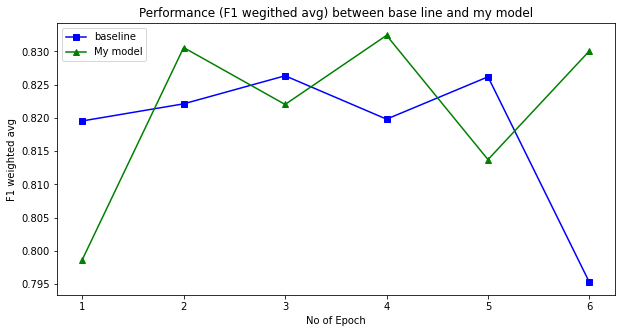

In [ ]:
no_of_epoch=[x+1 for x in range(6)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,f1_base,color='blue',marker='s',label='baseline')
plt.plot(no_of_epoch,f1_attention,color='green',marker='^',label='My model')
plt.legend()
plt.title('Performance (F1 wegithed avg) between base line and my model')
plt.xlabel('No of Epoch')
plt.ylabel('F1 weighted avg')

Text(0, 0.5, 'Validation Accuracy')

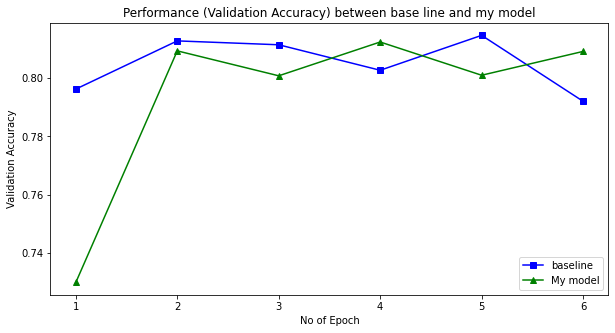

In [ ]:
no_of_epoch=[x+1 for x in range(6)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,accuracy_base,color='blue',marker='s',label='baseline')
plt.plot(no_of_epoch,accuracy_attention,color='green',marker='^',label='My model')
plt.legend()
plt.title('Performance (Validation Accuracy) between base line and my model')
plt.xlabel('No of Epoch')
plt.ylabel('Validation Accuracy')

In [ ]:
###################################################################################
##############################Evaluation Section2 #################################
###################################################################################

In [ ]:
########### To test performance with different input features
layer=1
epoch=5
model_validation_accuracy2={'word embedding only':0,'word embed + pre&next word':0,'word embed + POS tagging':0,'word embed+pre&next word + POS tagging':0}
model_validation_f1_score_weighted2={'word embedding only':0,'word embed + pre&next word':0,'word embed + POS tagging':0,'word embed+pre&next word + POS tagging':0}


model_attention1_CRF = BiLSTM_CRF1(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM) #base word embedding only with dot product attention
a,b,base_feature_acc,base_feature_f1 = train_with_norm_ebed(epoch,model_attention1_CRF,train_x,train_y,train_index,train_target,valid_index,valid_target,cal_acc)
model_validation_accuracy2['word embedding only'] = a
model_validation_f1_score_weighted2['word embedding only'] = b

model_attention2_CRF = BiLSTM_CRF2(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM) #base word embedding only + previous & next word with dot product attention
a,b,neighbour_word_acc,neighbour_word_f1 = train_with_norm_ebed(epoch,model_attention2_CRF,train_x,train_y,train_index,train_target,valid_index,valid_target,cal_acc)
model_validation_accuracy2['word embed + pre&next word'] = a
model_validation_f1_score_weighted2['word embed + pre&next word'] = b


model_postag_only_embedding = BiLSTM_CRF_stacked_pos_only(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))  #with base word embeding + POS tagging with dot product attention
a,b,POS_acc,POS_f1 = train_with_extra_ebed(epoch,model_postag_only_embedding,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy2['word embed + POS tagging'] = a
model_validation_f1_score_weighted2['word embed + POS tagging'] = b


model_postag_embedding_stacked = BiLSTM_CRF_stacked_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag)) #with base word embeding + POS tagging + next & previous word with dot product attention
a,b,all_acc,all_f1 =train_with_extra_ebed(epoch,model_postag_embedding_stacked,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2) 
model_validation_accuracy2['word embed+pre&next word + POS tagging'] = a
model_validation_f1_score_weighted2['word embed+pre&next word + POS tagging'] = b

loss with sentence 50  : 69.5538101196289
loss with sentence 100  : 11.247760772705078
loss with sentence 150  : 9.19046401977539
loss with sentence 200  : 45.459022521972656
loss with sentence 250  : 36.95813751220703
loss with sentence 300  : 40.28253936767578
loss with sentence 350  : 11.528892517089844
loss with sentence 400  : 15.848258972167969
loss with sentence 450  : 16.418739318847656
loss with sentence 500  : 16.84090805053711
loss with sentence 550  : 38.161903381347656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


-----------Accuracy with epoch1---------: 85.02409%
Valid Accuracy: 77.47440%
validation F1 weighted: 0.808
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.414     0.706     0.522       109
 B-MilitaryPlatform      0.000     0.000     0.000         1
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.579     0.661     0.617       245
           B-Person      0.725     0.592     0.652       125
         B-Quantity      0.182     0.769     0.294        13
         B-Temporal      0.489     0.742     0.590        31
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.294     0.696     0.414       112
 I-MilitaryPlatform      0.062     1.000     0.118         1
            I-Money      0.000     0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss with sentence 50  : 3.242706298828125
loss with sentence 100  : 16.470611572265625
loss with sentence 150  : 2.622509002685547
loss with sentence 200  : 18.38542938232422
loss with sentence 250  : 0.3012504577636719
loss with sentence 300  : 11.125083923339844
loss with sentence 350  : 0.7653656005859375
loss with sentence 400  : 2.0022411346435547
loss with sentence 450  : 3.93475341796875
loss with sentence 500  : 17.151321411132812
loss with sentence 550  : 12.583324432373047
-----------Accuracy with epoch2---------: 89.38047%
Valid Accuracy: 79.71179%
validation F1 weighted: 0.819
                     precision    recall  f1-score   support

B-DocumentReference      0.100     1.000     0.182         2
         B-Location      0.500     0.732     0.594       127
 B-MilitaryPlatform      0.125     0.500     0.200         4
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.689     0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 83.17161%
Valid Accuracy: 76.05233%
validation F1 weighted: 0.792
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.231     0.614     0.336        70
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.593     0.654     0.622       254
           B-Person      0.686     0.795     0.737        88
         B-Quantity      0.255     0.560     0.350        25
         B-Temporal      0.277     0.650     0.388        20
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.475     0.477     0.476       264
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.

In [ ]:
print(model_validation_accuracy2)
print(model_validation_f1_score_weighted2)

{'word embedding only': 0.8054607508532423, 'word embed + pre&next word': 0.8003412969283277, 'word embed + POS tagging': 0.8100113765642776, 'word embed+pre&next word + POS tagging': 0.8174061433447098}
{'word embedding only': 0.825511235409965, 'word embed + pre&next word': 0.8244761653914642, 'word embed + POS tagging': 0.8272295737200296, 'word embed+pre&next word + POS tagging': 0.8398054805118543}


In [ ]:
print(base_feature_acc)
print(base_feature_f1)
print(neighbour_word_acc)
print(neighbour_word_f1)
print(POS_acc)
print(POS_f1)
print(all_acc)
print(all_f1)

[0.7747440273037542, 0.7971179370496777, 0.7986348122866894, 0.8054607508532423, 0.80128934395146]
[0.8079176068135266, 0.8191332549462685, 0.8225749578478567, 0.825511235409965, 0.8190289990997708]
[0.7506636329161926, 0.7872582480091013, 0.7993932499051953, 0.8003412969283277, 0.7938945771710277]
[0.8037817817634435, 0.8177283901280763, 0.824204616516335, 0.8244761653914642, 0.8226581982499147]
[0.7605233219567691, 0.7952218430034129, 0.8077360637087599, 0.8100113765642776, 0.8084945013272659]
[0.7923416980258494, 0.8211730628146062, 0.8264938680999059, 0.8272295737200296, 0.8255466254395399]
[0.7646947288585514, 0.7834660599165718, 0.8100113765642776, 0.7973075464543041, 0.8174061433447098]
[0.8029883306327428, 0.8051717984379836, 0.8302964316278029, 0.8213366149248433, 0.8398054805118543]


Text(0, 0.5, 'Validation F1-score weighted avg')

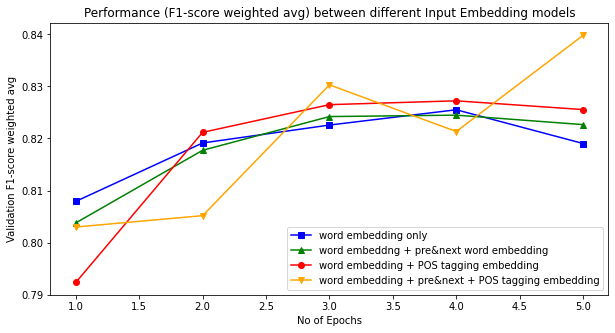

In [ ]:
no_of_epoch=[x+1 for x in range(5)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,base_feature_f1,color='blue',marker='s',label='word embedding only')
plt.plot(no_of_epoch,neighbour_word_f1,color='green',marker='^',label='word embeddng + pre&next word embedding')
plt.plot(no_of_epoch,POS_f1,color='red',marker='o',label='word embedding + POS tagging embedding')
plt.plot(no_of_epoch,all_f1,color='orange',marker='v',label='word embedding + pre&next + POS tagging embedding')
plt.legend()
plt.title('Performance (F1-score weighted avg) between different Input Embedding models')
plt.xlabel('No of Epochs')
plt.ylabel('Validation F1-score weighted avg')

Text(0, 0.5, 'Validation Accuracy')

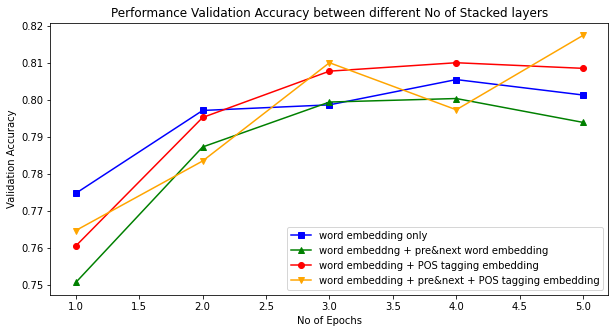

In [ ]:
no_of_epoch=[x+1 for x in range(5)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,base_feature_acc,color='blue',marker='s',label='word embedding only')
plt.plot(no_of_epoch,neighbour_word_acc,color='green',marker='^',label='word embeddng + pre&next word embedding')
plt.plot(no_of_epoch,POS_acc,color='red',marker='o',label='word embedding + POS tagging embedding')
plt.plot(no_of_epoch,all_acc,color='orange',marker='v',label='word embedding + pre&next + POS tagging embedding')
plt.legend()
plt.title('Performance Validation Accuracy between different No of Stacked layers')
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')

In [ ]:
###################################################################################
##############################Evaluation Section3 #################################
###################################################################################

In [ ]:
############different types of attention#########################
layer=1
model_validation_accuracy3={'Dot Product Attention':0,'Scaled Dot Product Attention':0,'Cosine Similarity Attention':0}
model_validation_f1_score_weighted3={'Dot Product Attention':0,'Scaled Dot Product Attention':0,'Cosine Similarity Attention':0}


EMBEDDING_DIM = 26
HIDDEN_DIM = 104

epoch=7

#for dot product attention with glove word embedding + POS tagging + previous&next word 
model_postag_embedding_stacked = BiLSTM_CRF_stacked_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag)) 
a,b,dot_acc_his,dot_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy3['Dot Product Attention'] = a
model_validation_f1_score_weighted3['Dot Product Attention'] = b

#for scale dot product attention with glove word embedding + POS tagging + previous&next word 
model_postag_embedding_scale_dot = BiLSTM_CRF_scale_product_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))
a,b,scale_dot_acc_his,scale_dot_f1_his =train_with_extra_ebed(epoch,model_postag_embedding_scale_dot,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy3['Scaled Dot Product Attention'] = a
model_validation_f1_score_weighted3['Scaled Dot Product Attention'] = b

#for cosine similarity attention with glove word embedding + POS tagging + previous&next word 
model_postag_embedding_cosine_sim = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,layer,len(pos_tag))
a,b,cosine_acc_his,cosine_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_cosine_sim,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy3['Cosine Similarity Attention'] = a
model_validation_f1_score_weighted3['Cosine Similarity Attention'] = b

loss with sentence 50  : 28.818336486816406
loss with sentence 100  : 26.737709045410156
loss with sentence 150  : 40.78828048706055
loss with sentence 200  : 14.744598388671875
loss with sentence 250  : 56.69300079345703
loss with sentence 300  : 9.809768676757812
loss with sentence 350  : 11.522354125976562
loss with sentence 400  : 40.54247283935547
loss with sentence 450  : 3.9496498107910156
loss with sentence 500  : 10.744182586669922
loss with sentence 550  : 19.897476196289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 82.83911%
Valid Accuracy: 76.71597%
validation F1 weighted: 0.81
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.323     0.682     0.438        88
 B-MilitaryPlatform      0.000     0.000     0.000         1
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.450     0.724     0.555       174
           B-Person      0.637     0.867     0.734        75
         B-Quantity      0.855     0.373     0.519       126
         B-Temporal      0.255     0.857     0.393        14
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.219     0.892     0.352        65
 I-MilitaryPlatform      0.000     0.000     0.000         2
            I-Money      0.000     0.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss with sentence 50  : 11.749458312988281
loss with sentence 100  : 3.073833465576172
loss with sentence 150  : 0.3130340576171875
loss with sentence 200  : 9.936431884765625
loss with sentence 250  : 7.755889892578125
loss with sentence 300  : 8.545249938964844
loss with sentence 350  : 25.991012573242188
loss with sentence 400  : 16.0009765625
loss with sentence 450  : 2.1616954803466797
loss with sentence 500  : 19.77410888671875
loss with sentence 550  : 9.480728149414062
-----------Accuracy with epoch2---------: 87.20228%
Valid Accuracy: 78.46037%
validation F1 weighted: 0.816
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.565     0.580     0.572       181
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.482     0.746  

In [ ]:
print("validation accuracy: {}".format(model_validation_accuracy3))
print("Validation F1 weighted avg: {}".format(model_validation_f1_score_weighted3))

validation accuracy: {'Dot Product Attention': 0.8128555176336746, 'Scaled Dot Product Attention': 0.8102009859689041, 'Cosine Similarity Attention': 0.8151308304891922}
Validation F1 weighted avg: {'Dot Product Attention': 0.8368144684750826, 'Scaled Dot Product Attention': 0.8311106835756651, 'Cosine Similarity Attention': 0.83063266077712}


Text(0, 0.5, 'Validation Accuracy')

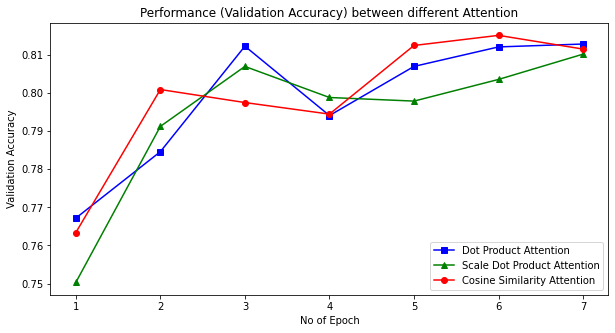

In [ ]:

no_of_epoch=[x+1 for x in range(7)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,dot_acc_his,color='blue',marker='s',label='Dot Product Attention')
plt.plot(no_of_epoch,scale_dot_acc_his,color='green',marker='^',label='Scale Dot Product Attention')
plt.plot(no_of_epoch,cosine_acc_his,color='red',marker='o',label='Cosine Similarity Attention')
plt.legend()
plt.title('Performance (Validation Accuracy) between different Attention')
plt.xlabel('No of Epoch')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'Validation F1-score weighted avg')

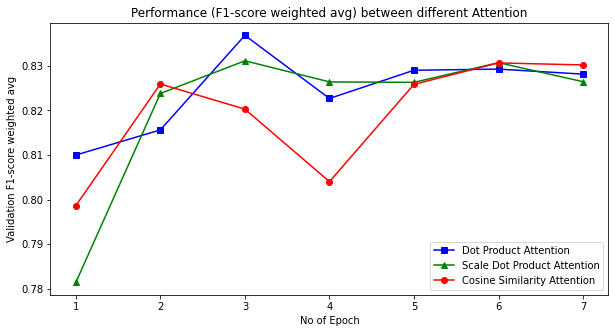

In [ ]:
no_of_epoch=[x+1 for x in range(7)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,dot_f1_his,color='blue',marker='s',label='Dot Product Attention')
plt.plot(no_of_epoch,scale_dot_f1_his,color='green',marker='^',label='Scale Dot Product Attention')
plt.plot(no_of_epoch,cosine_f1_his,color='red',marker='o',label='Cosine Similarity Attention')
plt.legend()
plt.title('Performance (F1-score weighted avg) between different Attention')
plt.xlabel('No of Epoch')
plt.ylabel('Validation F1-score weighted avg')

In [ ]:
###################################################################################
##############################Evaluation Section4 #################################
###################################################################################

In [ ]:
############different numbers of stacked LSTM layer#########################
model_validation_accuracy4={'1 stacked layer':0,'2 stacked layers':0,'3 stacked layers':0,'4 stacked layers':0,'5 stacked layers':0}
model_validation_f1_score_weighted4={'1 stacked layer':0,'2 stacked layers':0,'3 stacked layers':0,'4 stacked layers':0,'5 stacked layers':0}

EMBEDDING_DIM = 26
HIDDEN_DIM = 104

epoch=5

model_postag_embedding_stacked1 = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,1,len(pos_tag)) 
a,b,one_acc_his,one_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked1,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy4['1 stacked layer'] = a
model_validation_f1_score_weighted4['1 stacked layer'] = b

model_postag_embedding_stacked2 = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,2,len(pos_tag)) 
a,b,two_acc_his,two_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked2,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy4['2 stacked layers'] = a
model_validation_f1_score_weighted4['2 stacked layers'] = b

model_postag_embedding_stacked3 = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,3,len(pos_tag)) 
a,b,three_acc_his,three_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked3,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy4['3 stacked layers'] = a
model_validation_f1_score_weighted4['3 stacked layers'] = b

model_postag_embedding_stacked4 = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,4,len(pos_tag)) 
a,b,four_acc_his,four_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked4,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy4['4 stacked layers'] = a
model_validation_f1_score_weighted4['4 stacked layers'] = b

model_postag_embedding_stacked5 = BiLSTM_CRF_stacked_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,5,len(pos_tag)) 
a,b,five_acc_his,five_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked5,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy4['5 stacked layers'] = a
model_validation_f1_score_weighted4['5 stacked layers'] = b



loss with sentence 50  : 0.36647462844848633
loss with sentence 100  : 29.55782699584961
loss with sentence 150  : 25.37799835205078
loss with sentence 200  : 10.306358337402344
loss with sentence 250  : 28.052597045898438
loss with sentence 300  : 3.0775985717773438
loss with sentence 350  : 9.332687377929688
loss with sentence 400  : 5.059356689453125
loss with sentence 450  : 13.043212890625
loss with sentence 500  : 3.81512451171875
loss with sentence 550  : 12.551864624023438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 83.23947%
Valid Accuracy: 77.11414%
validation F1 weighted: 0.812
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.586     0.596     0.591       183
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.379     0.774     0.508       137
           B-Person      0.706     0.857     0.774        84
         B-Quantity      0.036     0.667     0.069         3
         B-Temporal      0.511     0.774     0.615        31
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.464     0.572     0.512       215
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss with sentence 50  : 11.145027160644531
loss with sentence 100  : 12.161666870117188
loss with sentence 150  : 9.593070983886719
loss with sentence 200  : 5.1859130859375
loss with sentence 250  : 4.961723327636719
loss with sentence 300  : 1.53179931640625
loss with sentence 350  : 1.2164592742919922
loss with sentence 400  : 23.25768280029297
loss with sentence 450  : 9.200996398925781
loss with sentence 500  : 4.1847991943359375
loss with sentence 550  : 17.5252685546875
-----------Accuracy with epoch2---------: 89.90975%
Valid Accuracy: 80.16686%
validation F1 weighted: 0.831
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.565     0.724     0.634       145
 B-MilitaryPlatform      0.062     1.000     0.118         1
            B-Money      0.200     1.000     0.333         1
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.664     0.738  

Text(0, 0.5, 'Validation Accuracy')

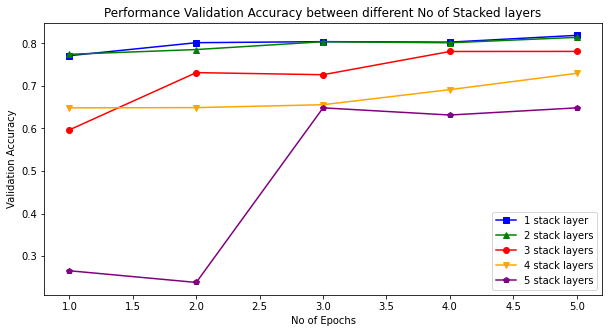

In [ ]:
no_of_epoch=[x+1 for x in range(5)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,one_acc_his,color='blue',marker='s',label='1 stack layer')
plt.plot(no_of_epoch,two_acc_his,color='green',marker='^',label='2 stack layers')
plt.plot(no_of_epoch,three_acc_his,color='red',marker='o',label='3 stack layers')
plt.plot(no_of_epoch,four_acc_his,color='orange',marker='v',label='4 stack layers')
plt.plot(no_of_epoch,five_acc_his,color='purple',marker='p',label='5 stack layers')
plt.legend()
plt.title('Performance Validation Accuracy between different No of Stacked layers')
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')

In [ ]:
print('best 1 layer accuracy: {}'.format(max(one_acc_his)))
print('best 2 layers accuracy: {}'.format(max(two_acc_his)))
print('best 3 layers accuracy: {}'.format(max(three_acc_his)))
print('best 4 layers accuracy: {}'.format(max(four_acc_his)))
print('best 5 layers accuracy: {}'.format(max(five_acc_his)))

best 1 layer accuracy: 0.8189230185817217
best 2 layers accuracy: 0.8141827834660599
best 3 layers accuracy: 0.7811907470610542
best 4 layers accuracy: 0.7296169890026545
best 5 layers accuracy: 0.6484641638225256


Text(0, 0.5, 'Validation F1-score weighted avg')

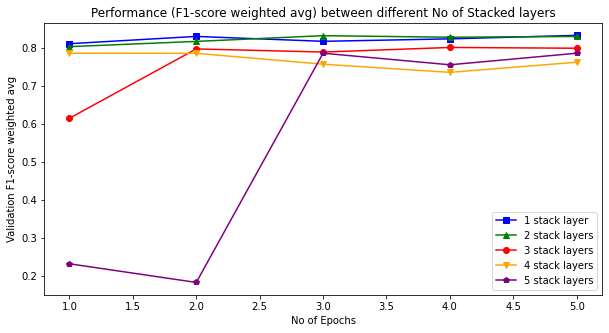

In [ ]:
no_of_epoch=[x+1 for x in range(5)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,one_f1_his,color='blue',marker='s',label='1 stack layer')
plt.plot(no_of_epoch,two_f1_his,color='green',marker='^',label='2 stack layers')
plt.plot(no_of_epoch,three_f1_his,color='red',marker='o',label='3 stack layers')
plt.plot(no_of_epoch,four_f1_his,color='orange',marker='v',label='4 stack layers')
plt.plot(no_of_epoch,five_f1_his,color='purple',marker='p',label='5 stack layers')
plt.legend()
plt.title('Performance (F1-score weighted avg) between different No of Stacked layers')
plt.xlabel('No of Epochs')
plt.ylabel('Validation F1-score weighted avg')

In [ ]:
print('best 1 layer F1 score (weighted avg): {}'.format(max(one_f1_his)))
print('best 2 layers F1 score (weighted avg): {}'.format(max(two_f1_his)))
print('best 3 layers F1 score (weighted avg): {}'.format(max(three_f1_his)))
print('best 4 layers F1 score (weighted avg): {}'.format(max(four_f1_his)))
print('best 5 layers F1 score (weighted avg): {}'.format(max(five_f1_his)))

best 1 layer F1 score (weighted avg): 0.8337745572245165
best 2 layers F1 score (weighted avg): 0.8329264638205313
best 3 layers F1 score (weighted avg): 0.801926445337055
best 4 layers F1 score (weighted avg): 0.7867494824016564
best 5 layers F1 score (weighted avg): 0.7867494824016564


In [ ]:
###################################################################################
##############################Evaluation Section5 #################################
###################################################################################

In [ ]:
##############CRF vs no CRF##########################
model_validation_accuracy5={'No CRF':0,'With CRF':0}
model_validation_f1_score_weighted5={'No CRF':0,'With CRF':0}

EMBEDDING_DIM = 26
HIDDEN_DIM = 104
layer=1

epoch=8

model_postag_embedding_withoutCRF = BiLSTM_noCRF_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,len(pos_tag))
a,b,noCRF_acc_his,noCRF_f1_his = train_with_extra_ebed_withoutCRF(epoch,model_postag_embedding_withoutCRF,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc3)
model_validation_accuracy5['No CRF'] = a
model_validation_f1_score_weighted5['No CRF'] = b

model_postag_embedding_stacked1 = BiLSTM_CRF_cosine_attention_pos(len(word_to_index), tag_to_index, EMBEDDING_DIM, HIDDEN_DIM,1,len(pos_tag)) 
a,b,CRF_acc_his,CRF_f1_his = train_with_extra_ebed(epoch,model_postag_embedding_stacked1,train_x,train_x_pos,train_y,train_index,train_target,valid_index,val_x_pos,valid_target,cal_acc2)
model_validation_accuracy5['with CRF'] = a
model_validation_f1_score_weighted5['with CRF'] = b



loss with sentence 50  : 1.0749844312667847
loss with sentence 100  : 1.32926607131958
loss with sentence 150  : 0.43242791295051575
loss with sentence 200  : 0.7750045657157898
loss with sentence 250  : 1.3315894603729248
loss with sentence 300  : 0.4778590202331543
loss with sentence 350  : 0.46634742617607117
loss with sentence 400  : 0.24598360061645508
loss with sentence 450  : 0.14117422699928284
loss with sentence 500  : 0.6788535118103027
loss with sentence 550  : 0.8975124955177307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 81.02056%
Valid Accuracy: 74.32689%
validation F1 weighted: 0.802
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.344     0.810     0.483        79
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.436     0.726     0.545       168
           B-Person      0.657     0.817     0.728        82
         B-Quantity      0.036     1.000     0.070         2
         B-Temporal      0.043     1.000     0.082         2
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.166     0.863     0.278        51
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss with sentence 50  : 0.18583901226520538
loss with sentence 100  : 0.3944139778614044
loss with sentence 150  : 0.3935133218765259
loss with sentence 200  : 1.105363368988037
loss with sentence 250  : 0.5439059138298035
loss with sentence 300  : 2.218648910522461
loss with sentence 350  : 1.1663405895233154
loss with sentence 400  : 1.240101933479309
loss with sentence 450  : 0.48595261573791504
loss with sentence 500  : 0.874792218208313
loss with sentence 550  : 0.8994498252868652
-----------Accuracy with epoch2---------: 86.08265%
Valid Accuracy: 77.64505%
validation F1 weighted: 0.816
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.414     0.802     0.546        96
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.443   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------Accuracy with epoch1---------: 84.15553%
Valid Accuracy: 77.56921%
validation F1 weighted: 0.815
                     precision    recall  f1-score   support

B-DocumentReference      0.000     0.000     0.000         0
         B-Location      0.441     0.678     0.534       121
 B-MilitaryPlatform      0.000     0.000     0.000         0
            B-Money      0.000     0.000     0.000         0
      B-Nationality      0.000     0.000     0.000         0
     B-Organisation      0.371     0.707     0.487       147
           B-Person      0.765     0.848     0.804        92
         B-Quantity      0.036     0.500     0.068         4
         B-Temporal      0.532     0.714     0.610        35
           B-Weapon      0.000     0.000     0.000         0
I-DocumentReference      0.000     0.000     0.000         0
         I-Location      0.423     0.783     0.549       143
 I-MilitaryPlatform      0.000     0.000     0.000         0
            I-Money      0.000     0.

In [ ]:
print(model_validation_accuracy5)
print(model_validation_f1_score_weighted5)

{'No CRF': 0.8081152825180129, 'With CRF': 0, 'with CRF': 0.8204398938187334}
{'No CRF': 0.831805784252099, 'With CRF': 0, 'with CRF': 0.8335049113842994}


In [ ]:
print(noCRF_acc_his)
print(noCRF_f1_his)
print(CRF_acc_his)
print(CRF_f1_his)

[0.7432688661357604, 0.7764505119453925, 0.7914296549108836, 0.7935153583617748, 0.7942737959802806, 0.7927569207432689, 0.8081152825180129, 0.8054607508532423]
[0.8023684934627967, 0.8156100856391421, 0.8226677231052306, 0.8205946925687991, 0.824662227464914, 0.8250575301460908, 0.831805784252099, 0.8243248405119237]
[0.7756920743268866, 0.79806598407281, 0.8113386423966629, 0.807356844899507, 0.8071672354948806, 0.8149412210845658, 0.8204398938187334, 0.8200606750094804]
[0.8145413607084828, 0.827466365184769, 0.8318262948279153, 0.8327934135778565, 0.8201208038851661, 0.8293997196737043, 0.8335049113842994, 0.830947011507585]


Text(0, 0.5, 'Validation Accuracy')

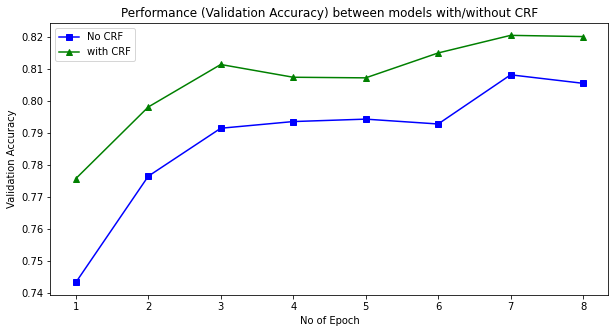

In [ ]:
no_of_epoch=[x+1 for x in range(8)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,noCRF_acc_his,color='blue',marker='s',label='No CRF')
plt.plot(no_of_epoch,CRF_acc_his,color='green',marker='^',label='with CRF')
plt.legend()
plt.title('Performance (Validation Accuracy) between models with/without CRF')
plt.xlabel('No of Epoch')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'F1 weighted avg')

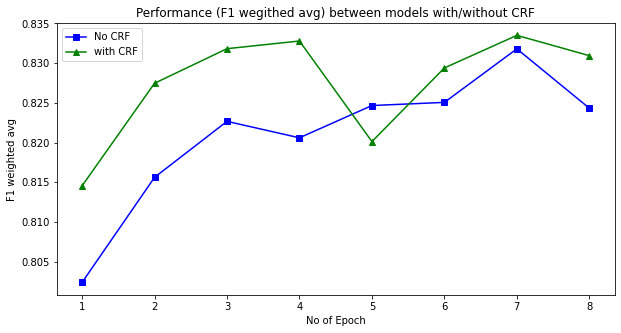

In [ ]:
no_of_epoch=[x+1 for x in range(8)]
plt.figure(figsize=(10,5)) 
plt.plot(no_of_epoch,noCRF_f1_his,color='blue',marker='s',label='No CRF')
plt.plot(no_of_epoch,CRF_f1_his,color='green',marker='^',label='with CRF')
plt.legend()
plt.title('Performance (F1 wegithed avg) between models with/without CRF')
plt.xlabel('No of Epoch')
plt.ylabel('F1 weighted avg')

In [ ]:
###############Best Model Tested####################

mymodel = torch.load('/content/gdrive/My Drive/Assignment2/best_model_cos v2.pt')

######### Use the best tested model to predict test dataset label###############
# a = test_index[1]

# b = torch.tensor(test_x_pos[1],dtype=torch.long)
test_labels=[]
mymodel.eval()
for x,y in zip(test_index,test_x_pos):
  y = torch.tensor(y,dtype=torch.long)
  result = mymodel(x,y)
  #result = model_attention2_CRF(x)
  for x in result[1]:
    test_labels.append(index_to_tag[x])

print(len(test_labels))
print(len(test_index))

id = [x+0 for x in range(len(test_labels))]
my_pred = {'ID':id,'Predicted':test_labels}
my_prediction = pd.DataFrame(my_pred)

my_prediction.to_csv('your3.csv', index=False)